<a href="https://colab.research.google.com/github/SeanSec/Application_Projects/blob/main/text_CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
!pip install tensorflow
!pip install datasets
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from datasets import load_dataset
import numpy as np
import pandas as pd
import time
import torch
from tqdm.auto import tqdm

tqdm.pandas()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Load dataset, define languages and labels for each

In [ ]:
langs = ['java', 'python', 'pharo']
labels = {
    'java': ['summary', 'Ownership', 'Expand', 'usage', 'Pointer', 'deprecation', 'rational'],
    'python': ['Usage', 'Parameters', 'DevelopmentNotes', 'Expand', 'Summary'],
    'pharo': ['Keyimplementationpoints', 'Example', 'Responsibilities', 'Classreferences', 'Intent', 'Keymessages', 'Collaborators']
}
ds = load_dataset('NLBSE/nlbse25-code-comment-classification')
ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

java_train-00000-of-00001.parquet:   0%|          | 0.00/680k [00:00<?, ?B/s]

java_test-00000-of-00001.parquet:   0%|          | 0.00/174k [00:00<?, ?B/s]

python_train-00000-of-00001.parquet:   0%|          | 0.00/126k [00:00<?, ?B/s]

python_test-00000-of-00001.parquet:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

pharo_train-00000-of-00001.parquet:   0%|          | 0.00/113k [00:00<?, ?B/s]

pharo_test-00000-of-00001.parquet:   0%|          | 0.00/30.6k [00:00<?, ?B/s]

Generating java_train split:   0%|          | 0/7614 [00:00<?, ? examples/s]

Generating java_test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

Generating python_train split:   0%|          | 0/1884 [00:00<?, ? examples/s]

Generating python_test split:   0%|          | 0/406 [00:00<?, ? examples/s]

Generating pharo_train split:   0%|          | 0/1298 [00:00<?, ? examples/s]

Generating pharo_test split:   0%|          | 0/289 [00:00<?, ? examples/s]

DatasetDict({
    java_train: Dataset({
        features: ['index', 'class', 'comment_sentence', 'partition', 'combo', 'labels'],
        num_rows: 7614
    })
    java_test: Dataset({
        features: ['index', 'class', 'comment_sentence', 'partition', 'combo', 'labels'],
        num_rows: 1725
    })
    python_train: Dataset({
        features: ['index', 'class', 'comment_sentence', 'partition', 'combo', 'labels'],
        num_rows: 1884
    })
    python_test: Dataset({
        features: ['index', 'class', 'comment_sentence', 'partition', 'combo', 'labels'],
        num_rows: 406
    })
    pharo_train: Dataset({
        features: ['index', 'class', 'comment_sentence', 'partition', 'combo', 'labels'],
        num_rows: 1298
    })
    pharo_test: Dataset({
        features: ['index', 'class', 'comment_sentence', 'partition', 'combo', 'labels'],
        num_rows: 289
    })
})

## Separate splits

In [ ]:
java_train = ds['java_train']
python_train = ds['python_train']
pharo_train = ds['pharo_train']

java_test = ds['java_test']
python_test = ds['python_test']
pharo_test = ds['pharo_test']

In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.17.1


## Find 98th percentile sentence length
This is to optimize our maximum sequence length

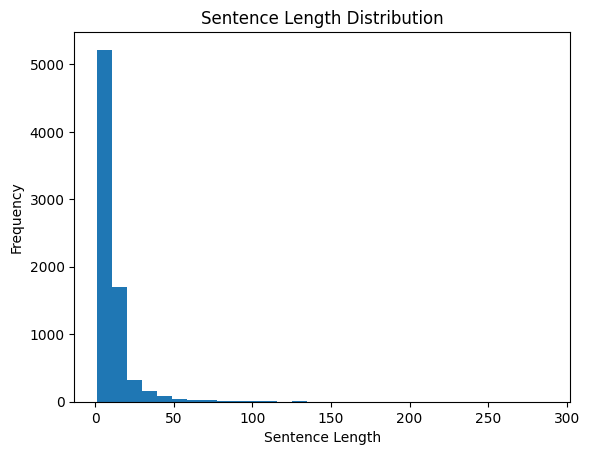

Max sequence length: 65


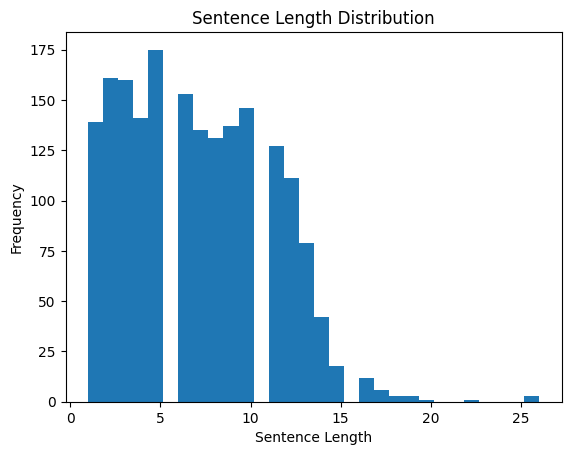

Max sequence length: 16


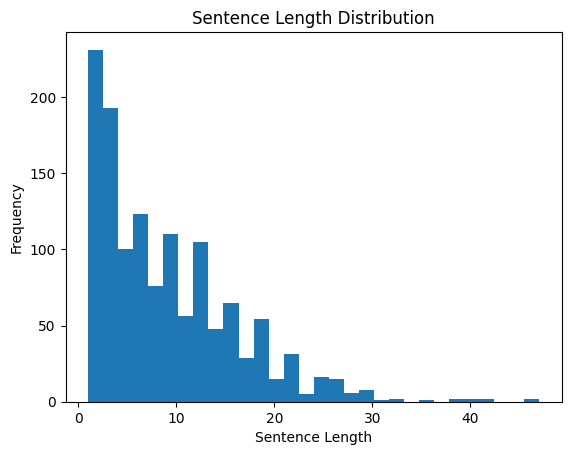

Max sequence length: 30


In [ ]:
import matplotlib.pyplot as plt

for lan in langs:
  sentence_lengths = [len(sentence.split()) for sentence in ds[f'{lan}_train']['comment_sentence']]

  plt.hist(sentence_lengths, bins=30)
  plt.xlabel('Sentence Length')
  plt.ylabel('Frequency')
  plt.title('Sentence Length Distribution')
  plt.show()

  # Max sequence length
  max_length = int(np.percentile(sentence_lengths, 99))
  print(f"Max sequence length: {max_length}")

## Tokenizer function

In [ ]:
tokenizer = Tokenizer(num_words=5000,)
def tokenize_data(data, tokenizer):
    return tokenizer.texts_to_sequences(data['comment_sentence'])

## Train models

In [ ]:
max_sequence_length = 64

for lan in langs:
    # Load the dataset variables for specific language
    train_data = globals()[f'{lan}_train']
    test_data = globals()[f'{lan}_test']

    # Fit tokenizer
    tokenizer.fit_on_texts(train_data['comment_sentence'])

    # Tokenize and pad sequences for specific language
    train_token = tokenize_data(train_data, tokenizer)
    test_token = tokenize_data(test_data, tokenizer)

    train_padded = pad_sequences(train_token, maxlen=max_sequence_length)
    test_padded = pad_sequences(test_token, maxlen=max_sequence_length)

    # Labels arrays
    train_labels = np.array(train_data['labels'])
    test_labels = np.array(test_data['labels'])

    # Set output dimension for specific language
    output_dim = len(train_labels[0])

    # CNN model for each language
    model = Sequential([
        Embedding(input_dim=5000, output_dim=128),
        Conv1D(256, 3, activation='relu'),
        MaxPooling1D(pool_size=4),
        Conv1D(256, 3, activation='relu'),
        MaxPooling1D(pool_size=4),
        Dropout(0.5),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(output_dim, activation='sigmoid')
    ])

    model.compile(optimizer= Adam(), loss= 'binary_crossentropy', metrics=['accuracy'])

    # Change the number of epochs and batch size for java vs python and pharo
    epoch = 0
    batch = 0
    if lan == 'java':
      epoch = 9
      batch = 32

      # Fit and save model
      model.fit(train_padded, train_labels, epochs=epoch, batch_size=batch, validation_data=(test_padded, test_labels))
      model.save(f'{lan}_cnn_model.keras')
    else:
      epoch = 8
      batch = 12

      # Fit and save model
      model.fit(train_padded, train_labels, epochs=epoch, batch_size=batch, validation_data=(test_padded, test_labels))
      model.save(f'{lan}_cnn_model.keras')

Epoch 1/9
238/238 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.4406 - loss: 0.3682 - val_accuracy: 0.6209 - val_loss: 0.2507
Epoch 2/9
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5585 - loss: 0.2604 - val_accuracy: 0.6464 - val_loss: 0.2381
Epoch 3/9
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6168 - loss: 0.2345 - val_accuracy: 0.6371 - val_loss: 0.2458
Epoch 4/9
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6513 - loss: 0.2083 - val_accuracy: 0.6296 - val_loss: 0.2547
Epoch 5/9
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6669 - loss: 0.1947 - val_accuracy: 0.6162 - val_loss: 0.2765
Epoch 6/9
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6911 - loss: 0.1848 - val_accuracy: 0.6157 - val_loss: 0.2979
Epoch 7/9
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6882 - loss: 0.1797 - val_accuracy: 0.6058 - val_loss: 0.3113
Epoch 8/9
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6807 - loss: 0.1820 - val_accuracy: 0.6006 -

## Testing

In [ ]:
def calc_scores(model, lan, tokenizer, max_sequence_length):
    global total_flops, total_time, scores
    test_data = globals()[f'{lan}_test']

    # Tokenize and pad test data
    test_token = tokenize_data(test_data, tokenizer)
    test_padded = pad_sequences(test_token, maxlen=max_sequence_length)
    y_true = np.array(test_data['labels']).T

    # Profiling and inference
    with torch.profiler.profile(with_flops=True) as p:
        begin = time.time()
        y_pred = model.predict(test_padded).T
        total = time.time() - begin

    # Update global metrics
    total_time += total
    total_flops += sum(k.flops for k in p.key_averages()) / 1e9

    # Calculate precision, recall, and F1 scores
    for i in range(len(y_pred)):
        assert len(y_pred[i]) == len(y_true[i])
        tp = sum((y_true[i] == 1) & (y_pred[i] > 0.5))
        tn = sum((y_true[i] == 0) & (y_pred[i] <= 0.5))
        fp = sum((y_true[i] == 0) & (y_pred[i] > 0.5))
        fn = sum((y_true[i] == 1) & (y_pred[i] <= 0.5))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        scores.append({
            'lan': lan,
            'cat': labels[lan][i],
            'precision': precision,
            'recall': recall,
            'f1': f1
        })

total_flops = 0
total_time = 0
scores = []

for lan in langs:
    # Load trained model
    model = tf.keras.models.load_model(f'{lan}_cnn_model.keras')

    # Calculate scores
    calc_scores(model, lan, tokenizer, max_sequence_length)

print("Compute in GFLOPs:", total_flops / 10)
print("Avg runtime in seconds:", total_time / 10)
scores = pd.DataFrame(scores)
scores

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Compute in GFLOPs: 0.0
Avg runtime in seconds: 0.3316930294036865


,lan,cat,precision,recall,f1
0,java,summary,0.592105,0.353139,0.442416
1,java,Ownership,0.000000,0.000000,0.000000
2,java,Expand,0.032787,0.039216,0.035714
3,java,usage,0.301205,0.116009,0.167504
4,java,Pointer,0.000000,0.000000,0.000000
5,java,deprecation,0.000000,0.000000,0.000000
6,java,rational,0.060606,0.029412,0.039604
7,python,Usage,0.114286,0.033058,0.051282
8,python,Parameters,0.411765,0.109375,0.172840
9,python,DevelopmentNotes,0.105263,0.097561,0.101266
